## Name: Jared Egerer
## Assignment: Project 4 - Sentiment Analysis of Reviews
## Date: 2 May 2023

### Introduction

All around the United States, different communities have different ideas of what pizza is.  From New York to Chicago to California, different regions serve different pies.  This analysis takes a look at the sentiment of pizza found in Chicago.  How strongly do the Chicago locals feel in favor of their local pizza joints?


**1. Import Libraries.**

In [87]:
import requests
import yelpkeys
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt

**2. Define functions used in querying the Yelp API, then perform search.**

In [52]:
APIKEY = yelpkeys.api_key
headers = {'Authorization': 'Bearer %s' % yelpkeys.api_key,}

In [53]:
"""
Yelp Fusion API code sample.
This program demonstrates the capability of the Yelp Fusion API
by using the Search API to query for businesses by a search term and location,
and the Business API to query additional information about the top result
from the search query.
Please refer to https://docs.developer.yelp.com/docs/get-started for the API
documentation.
This program requires the Python requests library, which you can install via:
`pip install -r requirements.txt`.
Sample usage of the program:
`python sample.py --term="bars" --location="San Francisco, CA"`
"""
from __future__ import print_function

import argparse
import json
import pprint
import requests
import sys
import urllib


# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode


# Yelp Fusion no longer uses OAuth as of December 7, 2017.
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app
API_KEY= yelpkeys.api_key


# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.


# Defaults for our simple example.
DEFAULT_TERM = 'pizza'
DEFAULT_LOCATION = 'San Francisco, CA'
SEARCH_LIMIT = 50


def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

In [54]:
response = search(API_KEY,DEFAULT_TERM, 'Chicago, IL')

Querying https://api.yelp.com/v3/businesses/search ...


In [8]:
response

{'businesses': [{'id': 'Bxd9Y2PsdvIOGIKFQh53RQ',
   'alias': 'giordanos-chicago-30',
   'name': "Giordano's",
   'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/OKxuR9ZqBNY-4wvP0Z0SPQ/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/giordanos-chicago-30?adjust_creative=FNzzjanQrcxG1g1P4bQOLg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=FNzzjanQrcxG1g1P4bQOLg',
   'review_count': 3456,
   'categories': [{'alias': 'pizza', 'title': 'Pizza'},
    {'alias': 'salad', 'title': 'Salad'},
    {'alias': 'italian', 'title': 'Italian'}],
   'rating': 4.0,
   'coordinates': {'latitude': 41.88513231411071,
    'longitude': -87.62375615999174},
   'transactions': ['delivery'],
   'price': '$$',
   'location': {'address1': '130 E Randolph St',
    'address2': '',
    'address3': '',
    'city': 'Chicago',
    'zip_code': '60601',
    'country': 'US',
    'state': 'IL',
    'display_address': ['130 E Randolph St', 'Chicago, IL 60601']},
   'phone': '+13

**3. Perform Sentiment analysis. Using results from the Sentiment analysis, plot donut charts of review sentiments.**

In [10]:
pos_reviews = 0
neg_reviews = 0
neutral_reviews = 0

pos_bayes = 0
neg_bayes = 0
neutral_bayes = 0

for business in response['businesses']:
    #print(response)
    print('Business Name: ' + business['name'])
    print('Rating: ' + str(business['rating']))
    print('Review Count: ' + str(business['review_count']))
    print('Reviews: ')
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    #print('https://api.yelp.com/v3/businesses/{}/reviews?limit=20&sort_by=yelp_sort'.format(business['id']))
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        print(' - ' + review['text'])
        # Perform sentiment analysis on the review using TextBlob
        blob = TextBlob(review['text'])
        sentiment = blob.sentiment.polarity
        print('Sentiment:')
        if sentiment > 0:
            print('    Sentiment: Positive')
            pos_reviews += 1
        elif sentiment < 0:
            print('    Sentiment: Negative')
            neg_reviews += 1
        else:
            print('    Sentiment: Neutral')
            neutral_reviews += 1
        print()
        blob2 = TextBlob(review['text'], analyzer = NaiveBayesAnalyzer())
        sentiment2 = blob2.sentiment.p_pos
        print('NaiveBayesAnalyzer Sentiment:')
        if sentiment2 > 0.5:
            print('    Sentiment: Positive\n')
            pos_bayes += 1
        elif sentiment2 < 0.5:
            print('    Sentiment: Negative\n')
            neg_bayes += 1
        else:
            print('    Sentiment: Neutral\n')
            neutral_bayes += 1

Business Name: Giordano's
Rating: 4.0
Review Count: 3456
Reviews: 
Querying https://api.yelp.com/v3/businesses/Bxd9Y2PsdvIOGIKFQh53RQ/reviews ...
 - Enjoy this place!  Love the interior decor.  Jose was a great server.  Attentive and suggested the house specialties.  Would come again when I'm in the area.
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - Always a favorite spot while visiting ChiTown. Usual order of Chicago Classic with sausage was excellent as always. Great experience. Our waiter, George,...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - Fantastic establishment! The bar tender Austin was attentive, mixed good drinks, and even let me borrow a phone charger! Will be back.
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

Business Name: Lou Malnati's Pizzeria
Rating: 4.0
Review Count: 7045
Reviews: 
Querying https://api.yelp.com/v3/businesses

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - The absolute worst. Do yourself a favor and go to Lou's or Giordano's. 

Server had an attitude problem from the second she came to the table. 

Salad came...
Sentiment:
    Sentiment: Negative

NaiveBayesAnalyzer Sentiment:
    Sentiment: Negative

 - I came here for lunch and it was my first time having deep dish pizza. 

Nice casual decor inside and my server was friendly and helpful.

The deep dish was...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

Business Name: Five Squared Pizza
Rating: 5.0
Review Count: 22
Reviews: 
Querying https://api.yelp.com/v3/businesses/511flt1E6niG0sK5FkX_fQ/reviews ...
 - Truly some of the best pizza ever eaten. Yes, you have to put it back in the oven for 10 minutes but it makes it so crispy and it's worth the wait. I have...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - First visit and it was alright.

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - My wife and I used to come here a lot when we lived in the neighborhood and it was still at its original location. We were in the area recently and wanted...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Negative

Business Name: Obbie's Pizza
Rating: 4.0
Review Count: 142
Reviews: 
Querying https://api.yelp.com/v3/businesses/7-K3Lcm9ng_9SmCvKBfbpw/reviews ...
 - Highly recommend this great neighborhood pizza place ! One of the best ! Great place for one of the best pizza's! Food is awesome ! From my experience the...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - Can I give this place a solid 3.5? Decent tavern style pizza serving the Southside. I was devastated to hear that my favorite Southside pizza place closed...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Negative

 - A family favorite since the early 1980

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

Business Name: Damenzo's Pizza
Rating: 3.0
Review Count: 174
Reviews: 
Querying https://api.yelp.com/v3/businesses/F5YgkiXenIcfdINYhQ3g4g/reviews ...
 - The food is great. The Delivery driver had a very Nasty and disgusting attitude. I won't be  ordering again for Delivery.
Sentiment:
    Sentiment: Negative

NaiveBayesAnalyzer Sentiment:
    Sentiment: Negative

 - To me the Italian Beef is the best!! We usually get take out but they seem eager to please so that's a plus! Thank you
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - Pretty authentic tacos rice and beans, friendly staff, really fast service, great hours, perfect for after perfect for after Riot Fest

My friend and I went...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

Business Name: Ricobene's
Rating: 4.0
Review Count: 1083
Reviews: 
Querying https://api.yelp.com/v3/businesses/a

 - What a gem!  Dimo's Pizza serves some of the best pizza slices in Wrigleyville. 

We have been to Dimo's plenty of times. I can't believe it took me this...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - I picked up a couple pizzas from here that I ordered online. I ordered a 12" Pep 2.0 for $19. The pizzas was honestly to small to justify that price, but...
Sentiment:
    Sentiment: Negative

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - Great slices!   I actually prefer the slices to the 12" pizzas.  The crust bakes differently and isn't quite as thin as the slices.  We go pretty standard:...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Negative

Business Name: Monti's
Rating: 4.5
Review Count: 775
Reviews: 
Querying https://api.yelp.com/v3/businesses/3HE0HPAOa4kS5y4OhzQfzg/reviews ...
 - One of the best cheesesteaks in the city. Consistent and always hits the spot. Well worth a visit if

NaiveBayesAnalyzer Sentiment:
    Sentiment: Negative

 - One of the worse pizza places I've tried in a while. Customer was decent but the pizza was absolutely sloppy, soo much dough it was like I was eating a...
Sentiment:
    Sentiment: Negative

NaiveBayesAnalyzer Sentiment:
    Sentiment: Negative

Business Name: Pizza 750
Rating: 5.0
Review Count: 22
Reviews: 
Querying https://api.yelp.com/v3/businesses/LP8GwlbgKrdrfJXLydtoPQ/reviews ...
 - 100% awesome pizza and great service. Owner made great recommendations to customize our pizzas. Very friendly atmosphere! JUST great..

The brick oven pizza...
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Positive

 - Good food, fast service. Clean and convenient for good eats while enjoying the microbrewery a couple doors down.
Sentiment:
    Sentiment: Positive

NaiveBayesAnalyzer Sentiment:
    Sentiment: Negative

 - Was there yesterday after having a few beers at Imperial Oak. So easy to order pizza with

In [12]:
print("Regular Analyzer:")
print("Positive: " + str(pos_reviews))
print("Negative: " + str(neg_reviews))
print("Neutral: " + str(neutral_reviews))
print()
print("Bayes Analyzer:")
print("Positive: " + str(pos_bayes))
print("Negative: " + str(neg_bayes))
print("Neutral: " + str(neutral_bayes))

Regular Analyzer:
Positive: 127
Negative: 15
Neutral: 8

Bayes Analyzer:
Positive: 121
Negative: 29
Neutral: 0


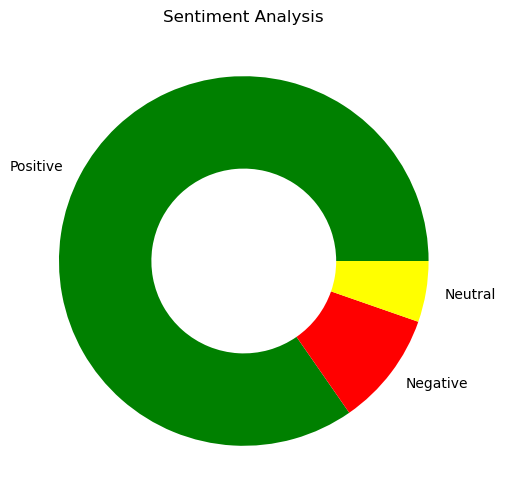

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define data
pos = pos_reviews
neg = neg_reviews
neut = neutral_reviews
labels = ['Positive', 'Negative', 'Neutral']
values = [pos, neg, neut]

# Create donut chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(values, labels=labels, wedgeprops=dict(width=0.5), colors=['green', 'red', 'yellow'])
ax.set_title('Sentiment Analysis')

plt.show()

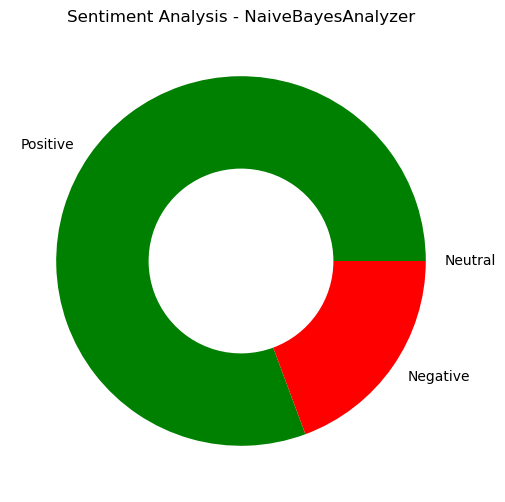

In [88]:
# Define data
pos_b = pos_bayes
neg_b = neg_bayes
neut_b = neutral_bayes
labels = ['Positive', 'Negative', 'Neutral']
values = [pos_b, neg_b, neut_b]

# Create donut chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(values, labels=labels, wedgeprops=dict(width=0.5), colors=['green', 'red', 'yellow'])
ax.set_title('Sentiment Analysis - NaiveBayesAnalyzer')

plt.show()

**4. Create a TextBlob using the reviews obtained for the Sentiment Analysis.  Using NLTK's list of Stop Words, remove the stop words.**

In [58]:
review_list = []

for business in response['businesses']:
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    for review in reviews['reviews']:
        review_list.append(review['text'])

Querying https://api.yelp.com/v3/businesses/Bxd9Y2PsdvIOGIKFQh53RQ/reviews ...
Querying https://api.yelp.com/v3/businesses/8vFJH_paXsMocmEO_KAa3w/reviews ...
Querying https://api.yelp.com/v3/businesses/DXwSYgiXqIVNdO9dazel6w/reviews ...
Querying https://api.yelp.com/v3/businesses/cxAkuwv7p4gm4Coixw7h9A/reviews ...
Querying https://api.yelp.com/v3/businesses/QNbWTNuAEMWOurHN8rMXnA/reviews ...
Querying https://api.yelp.com/v3/businesses/2cDt9At556hf146QH_XkhQ/reviews ...
Querying https://api.yelp.com/v3/businesses/hxq4TNNazA-sjqFvVgx_Pw/reviews ...
Querying https://api.yelp.com/v3/businesses/wiNuegM8MNw9WIP0wfMmeA/reviews ...
Querying https://api.yelp.com/v3/businesses/LrcRLcCGsSNJjTKKK9UgYw/reviews ...
Querying https://api.yelp.com/v3/businesses/ibreTMGGaQSanZttUchjKg/reviews ...
Querying https://api.yelp.com/v3/businesses/0ZENqrACvQ4tiMvFEkgVPg/reviews ...
Querying https://api.yelp.com/v3/businesses/511flt1E6niG0sK5FkX_fQ/reviews ...
Querying https://api.yelp.com/v3/businesses/z8G5AfXY

In [59]:
review_list

["Enjoy this place!  Love the interior decor.  Jose was a great server.  Attentive and suggested the house specialties.  Would come again when I'm in the area.",
 'Always a favorite spot while visiting ChiTown. Usual order of Chicago Classic with sausage was excellent as always. Great experience. Our waiter, George,...',
 'Fantastic establishment! The bar tender Austin was attentive, mixed good drinks, and even let me borrow a phone charger! Will be back.',
 'Hey!\ni went to this restaurant with friends and family, and to leave an honest review; it was amazing. the Personal pizza option on the menu was perfect for...',
 "Amazing gluten free deep dish! I'd come back any time for more. Service was good too.",
 "This is Chicago food at its best. There is pizza and then there is Lou's. Whether you like thin cut or pan pizza, they are both true perfection. My favorite...",
 'it can take a while to get a table but it is worth the wait! deep dish better than any of the other guys around town.

In [60]:
review_blob = TextBlob(' '.join(review_list))

In [61]:
items = review_blob.word_counts.items()
print(len(items))
items

1068


dict_items([('enjoy', 1), ('this', 50), ('place', 30), ('love', 15), ('the', 227), ('interior', 1), ('decor', 2), ('jose', 1), ('was', 79), ('a', 127), ('great', 30), ('server', 6), ('attentive', 3), ('and', 124), ('suggested', 1), ('house', 1), ('specialties', 1), ('would', 5), ('come', 4), ('again', 3), ('when', 8), ('i', 131), ('m', 5), ('in', 57), ('area', 2), ('always', 14), ('favorite', 11), ('spot', 10), ('while', 8), ('visiting', 3), ('chitown', 1), ('usual', 1), ('order', 10), ('of', 74), ('chicago', 33), ('classic', 2), ('with', 23), ('sausage', 4), ('excellent', 4), ('as', 23), ('experience', 4), ('our', 13), ('waiter', 2), ('george', 1), ('fantastic', 3), ('establishment', 1), ('bar', 4), ('tender', 1), ('austin', 1), ('mixed', 1), ('good', 18), ('drinks', 3), ('even', 3), ('let', 4), ('me', 12), ('borrow', 1), ('phone', 2), ('charger', 1), ('will', 10), ('be', 19), ('back', 11), ('hey', 3), ('went', 4), ('to', 79), ('restaurant', 8), ('friends', 4), ('family', 9), ('leave'

In [62]:
items = [item for item in items if item[0] not in stop_words]
len(items)

966

In [86]:
stop_words = set(stopwords.words('english'))

In [63]:
items

[('enjoy', 1),
 ('place', 30),
 ('love', 15),
 ('interior', 1),
 ('decor', 2),
 ('jose', 1),
 ('great', 30),
 ('server', 6),
 ('attentive', 3),
 ('suggested', 1),
 ('house', 1),
 ('specialties', 1),
 ('would', 5),
 ('come', 4),
 ('area', 2),
 ('always', 14),
 ('favorite', 11),
 ('spot', 10),
 ('visiting', 3),
 ('chitown', 1),
 ('usual', 1),
 ('order', 10),
 ('chicago', 33),
 ('classic', 2),
 ('sausage', 4),
 ('excellent', 4),
 ('experience', 4),
 ('waiter', 2),
 ('george', 1),
 ('fantastic', 3),
 ('establishment', 1),
 ('bar', 4),
 ('tender', 1),
 ('austin', 1),
 ('mixed', 1),
 ('good', 18),
 ('drinks', 3),
 ('even', 3),
 ('let', 4),
 ('borrow', 1),
 ('phone', 2),
 ('charger', 1),
 ('back', 11),
 ('hey', 3),
 ('went', 4),
 ('restaurant', 8),
 ('friends', 4),
 ('family', 9),
 ('leave', 3),
 ('honest', 2),
 ('review', 5),
 ('amazing', 14),
 ('personal', 1),
 ('pizza', 101),
 ('option', 2),
 ('menu', 3),
 ('perfect', 6),
 ('gluten', 2),
 ('free', 2),
 ('deep', 22),
 ('dish', 19),
 ('time'

**5. Take Top 20 Words from TextBlob, clean data, and create a WordCloud from the resulting list.**

In [64]:
from operator import itemgetter

In [65]:
sorted_items = sorted(items, key=itemgetter(1), reverse=True)

In [66]:
top_20 = sorted_items[0:20]
top_20

[('pizza', 101),
 ('best', 34),
 ('chicago', 33),
 ('place', 30),
 ('great', 30),
 ('crust', 27),
 ('deep', 22),
 ('service', 20),
 ('food', 20),
 ('dish', 19),
 ('one', 19),
 ('good', 18),
 ("n't", 18),
 ('love', 15),
 ('time', 15),
 ('thin', 15),
 ('always', 14),
 ('amazing', 14),
 ('pizzas', 13),
 ('favorite', 11)]

In [70]:
df = pd.DataFrame(top_20, columns=['word','count'])

In [71]:
df

,word,count
0,pizza,101
1,best,34
2,chicago,33
3,place,30
4,great,30
5,crust,27
6,deep,22
7,service,20
8,food,20
9,dish,19


In [72]:
df = df.drop(df.index[12])
df

,word,count
0,pizza,101
1,best,34
2,chicago,33
3,place,30
4,great,30
5,crust,27
6,deep,22
7,service,20
8,food,20
9,dish,19


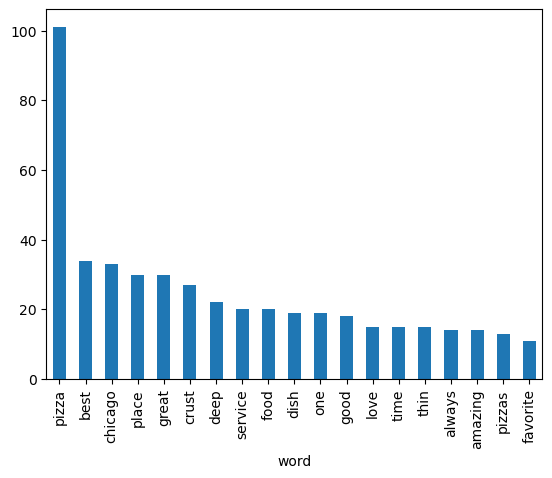

In [73]:
axes = df.plot.bar(x='word', y='count', legend=False)

In [74]:
from wordcloud import WordCloud

In [81]:
wordcloud = WordCloud(colormap='prism',background_color='white', max_words=20)

In [82]:
text = ' '.join(review_list)

In [83]:
wordcloud = wordcloud.generate(text)

In [84]:
wordcloud = wordcloud.to_file('ChicagoPizza.png')

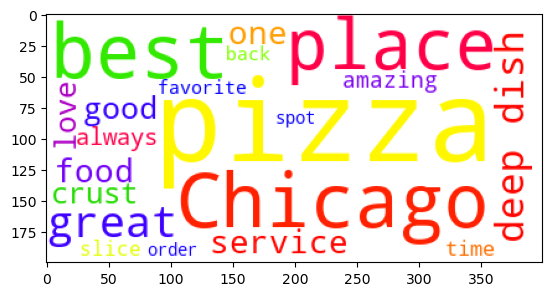

In [85]:
plt.imshow(wordcloud)

### Conclusion

Much like New Yorkers will aggressively promote and defend their pizza, so too will Chicagoans their deep dish.  From the Sentiment Analysis, the two analyzing modules believe between 80-85% of the 150 reviews sampled are positive.  Looking at the top 20 words, it doesn't come as a surprise, then, that "best," "great," "good," "amazing," and "favorite" are all included.